In [93]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

import spacy

import gc

import geopy.distance

nlp = spacy.load('en_core_web_lg')
from sklearn.metrics.pairwise import cosine_similarity

import itertools

# Indirect
Introduce the SC Data.

In [59]:
c_links = pd.read_csv("../../data/companyData/compustatSCLinked.csv") # pd.read_csv("../../data/companyData/compustatSCLinked.csv")

c_links['year'] = c_links.srcdate.astype('str').str.slice(0,4).astype('int64')

c_links = c_links[c_links.year > 1999][['year','gvkey','cgvkey','salecs']].\
    rename(columns = {'cgvkey': 'customer_gvkey','gvkey': 'supplier_gvkey'})

c_links['year'] = pd.to_datetime(c_links.year, format = '%Y')


c_links.head()

,year,supplier_gvkey,customer_gvkey,salecs
70,2002-01-01,1013,2136,111.056
71,2004-01-01,1013,2136,104.312
72,2005-01-01,1013,2136,146.000
73,2006-01-01,1013,2136,205.000
74,2007-01-01,1013,2136,236.000


In [60]:
supplierCombos = c_links[['supplier_gvkey', 'customer_gvkey']].drop_duplicates().reset_index(drop = True)

print(supplierCombos.shape)

supplierCombos.head()

(16812, 2)


,supplier_gvkey,customer_gvkey
0,1013,2136
1,1013,9899
2,1021,61494
3,1021,25880
4,1048,11552


We'll follow Barrot Sauvagnat in assuming that a supplier relationship holds for every year between the first and last year in which a customer is reported. This is going to take a little bit of work. We'll try it like this: 
- subset dataframe to a specific supplier-customer pair
- fill in data for every year that's missing

Then, apply this row-wise to all rows of the unique supplierCombos df above using: https://stackoverflow.com/questions/61942138/apply-function-row-wise-to-pandas-dataframe

In [61]:
def fillYear(supplier, customer, scData = c_links):
    c_linksTemp = scData[(scData.supplier_gvkey == supplier) & \
                      (scData.customer_gvkey == customer)].reset_index(drop = True)
    
    # if there are na values and non-na values for the same supplier-cust combination, then 
    # select for only the non-na values, by (1) replacing na with negative, (2) 1
    c_linksTemp['salecs'] = c_linksTemp['salecs'].fillna(-5)
    c_linksTemp = c_linksTemp.loc[c_linksTemp.reset_index().groupby(['year','supplier_gvkey',
                                                                     'customer_gvkey'])['salecs'].idxmax()]

    
    # now: find the start and end of the data series
    first = c_linksTemp.year.min()
    last  = c_linksTemp.year.max()

    c_linksTemp = c_linksTemp.set_index('year') 

    c_linksTemp = c_linksTemp.reindex(pd.date_range(first, last, freq = 'YS')).\
        reset_index().rename(columns = {'index': 'year'})

    # and impute all values within the series
    c_linksTemp = c_linksTemp.groupby(c_linksTemp.year.dt.time).ffill()
    
    return(c_linksTemp)

Show that this works for one of the supplier rows.

In [62]:
fillYear(supplierCombos.supplier_gvkey[0], supplierCombos.customer_gvkey[0])

,year,supplier_gvkey,customer_gvkey,salecs
0,2002-01-01,1013.0,2136.0,111.056
1,2003-01-01,1013.0,2136.0,111.056
2,2004-01-01,1013.0,2136.0,104.312
3,2005-01-01,1013.0,2136.0,146.000
4,2006-01-01,1013.0,2136.0,205.000
5,2007-01-01,1013.0,2136.0,236.000
6,2008-01-01,1013.0,2136.0,240.000
7,2009-01-01,1013.0,2136.0,176.000
8,2010-01-01,1013.0,2136.0,146.000


Now do it for all rows.

In [63]:
start = time.time()
print(c_links.shape)
c_linksImpd_list = supplierCombos.apply(lambda row: fillYear(row['supplier_gvkey'], row['customer_gvkey']), axis = 1)
c_linksImpd_df   = pd.concat(list(c_linksImpd_list))
print(c_linksImpd_df.shape)
print(time.time() - start)

c_linksImpd_df['year'] = c_linksImpd_df.year.dt.year

(65270, 4)
(68771, 4)
70.72920513153076


We had converted some of the na sales values to -5 so that we could deal with duplicated values, by choosing the larger of said values. Switch back to nan so that we are not thrown off when we look for biggest supplier.

In [64]:
c_linksImpd_df.loc[c_linksImpd_df.salecs == -5, 'salecs'] = float('nan')

In [337]:
industries = pd.read_csv("../../data/companyData/gvkeyIndustries.csv").drop(columns = {'Unnamed: 0'})
print(industries)

       gvkey   indGroup
0       1004  wholesale
1       1082   services
2       1244       manu
3       1258     mining
4       1331       manu
...      ...        ...
25519  34542    finance
25520  34549    finance
25521  34553    finance
25522  34556    finance
25523  34583    finance

[25524 rows x 2 columns]


In [338]:
c_links = c_linksImpd_df.copy()

print(c_links.shape)

print(c_links.head())

industries.columns = ['customer_gvkey','customer_ind']


c_links = c_links.merge(industries)
industries.columns = ['supplier_gvkey','supplier_ind']

c_links = c_links.merge(industries)
print(c_links.head(), c_links.shape)


c_links.to_csv("../../data/companyData/c_links.csv")


(68771, 4)
   year  supplier_gvkey  customer_gvkey   salecs
0  2002          1013.0          2136.0  111.056
1  2003          1013.0          2136.0  111.056
2  2004          1013.0          2136.0  104.312
3  2005          1013.0          2136.0  146.000
4  2006          1013.0          2136.0  205.000
   year  supplier_gvkey  customer_gvkey   salecs        customer_ind  \
0  2002          1013.0          2136.0  111.056  transportUtilities   
1  2003          1013.0          2136.0  111.056  transportUtilities   
2  2004          1013.0          2136.0  104.312  transportUtilities   
3  2005          1013.0          2136.0  146.000  transportUtilities   
4  2006          1013.0          2136.0  205.000  transportUtilities   

  supplier_ind  
0         manu  
1         manu  
2         manu  
3         manu  
4         manu   (67025, 6)


Let's see how all this translates into different industries. Check how many times different industries show up.

The full count will be roughly 4x whatever is below, assuming we can get a match for roughly all of them (which we should be able to).

In [339]:
c_links[c_links.year.astype(int) > 2009].supplier_ind.value_counts()

manu                  15708
finance                8285
services               4309
mining                 2897
transportUtilities     1978
wholesale               820
construction            265
retail                  172
agForFish                62
Name: supplier_ind, dtype: int64

Now see if it's common to have one in and one out of the industries of interest. 

For now, let's keep all the different industry types.

We can always filter later if we need to.


********this is where it would be helpful to check on the abi bits for a given industry, to see if we can get additional matches as well***********

In [341]:
#########################
# get data and reset columns 
gvKey_abiLinkingTable = pd.read_csv('../../data/companyData/linkingTable.csv').drop(columns = ['Unnamed: 0']).\
    drop_duplicates()




base_columns = gvKey_abiLinkingTable.columns 
customer_columns = "customer_" + base_columns
supplier_columns = "supplier_" + base_columns




# merge in customer information
gvKey_abiLinkingTable.columns = customer_columns



print(c_links.shape)
c_linksMerge1 = c_links.merge(gvKey_abiLinkingTable, on ='customer_gvkey')
print(c_links.shape,c_linksMerge1.shape, c_linksMerge1.head())





#########################
# and merge in supplier 
gvKey_abiLinkingTable.columns = supplier_columns

print(c_links.shape)
c_linksMerge2 = c_linksMerge1.merge(gvKey_abiLinkingTable, on ='supplier_gvkey').drop_duplicates()
print(c_linksMerge2.shape)

c_linksMerge2.to_csv("../../data/companyData/clinks_IG_selected.csv")

(67025, 6)
(67025, 6) (47611, 10)    year  supplier_gvkey  customer_gvkey   salecs        customer_ind  \
0  2002          1013.0          2136.0  111.056  transportUtilities   
1  2003          1013.0          2136.0  111.056  transportUtilities   
2  2004          1013.0          2136.0  104.312  transportUtilities   
3  2005          1013.0          2136.0  146.000  transportUtilities   
4  2006          1013.0          2136.0  205.000  transportUtilities   

  supplier_ind customer_cstatCompanies customer_igCompanies  customer_delete  \
0         manu     verizonmmunications  verizonmmunications              NaN   
1         manu     verizonmmunications  verizonmmunications              NaN   
2         manu     verizonmmunications  verizonmmunications              NaN   
3         manu     verizonmmunications  verizonmmunications              NaN   
4         manu     verizonmmunications  verizonmmunications              NaN   

   customer_abi  
0       7564776  
1       7564776 

In [342]:
c_linksMerge2.head()

,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_delete,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_delete,supplier_abi
0,2002,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
1,2003,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
2,2004,1013.0,2136.0,104.312,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
3,2005,1013.0,2136.0,146.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
4,2006,1013.0,2136.0,205.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129


This is probably because: (1) companies are not in North America, or (2) companies are not in the physical goods industries we're interested in. We can verify this though: look at c_links where both the customer and supplier are in the dataset of interest.

In [343]:
chq     = pd.read_csv("../../data/chq.csv",dtype={'cstatZipcode': 'object'}).drop(columns = {'Unnamed: 0'})

c_linkTest = c_links[c_links.customer_gvkey.isin(chq.gvkey.unique()) & \
                     c_links.supplier_gvkey.isin(chq.gvkey.unique())]

print("Percent of firms with a match: ", c_linksMerge2.shape[0]/c_linkTest.shape[0])

Percent of firms with a match:  0.7092245720040282


Let's check this with the IG headquarters as well.

In [344]:
c_linksMerge2.head()

,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_delete,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_delete,supplier_abi
0,2002,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
1,2003,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
2,2004,1013.0,2136.0,104.312,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
3,2005,1013.0,2136.0,146.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
4,2006,1013.0,2136.0,205.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129


It's entirely possible that we have too small of a sample from the 2010s alone. Let's just try it though and see how it goes.

First, make a sample with the companies on one year of either side of when it reports another customer.

In [345]:
def makeOneEitherSide(df): 
    yrPlus1 = df.copy(); yrPlus1['year'] += 1
    # yrPlus2 = df.copy(); yrPlus2['year'] += 1
    # yrPlus3 = df.copy(); yrPlus3['year'] += 1
    
    yrMinus1 = df.copy(); yrMinus1['year'] -= 1
    # yrMinus2 = df.copy(); yrMinus2['year'] -= 1
    # yrMinus3 = df.copy(); yrMinus3['year'] -= 1
    
    all = pd.concat([yrPlus1,yrMinus1]) # pd.concat([yrPlus1,yrPlus2,yrPlus3,yrMinus1,yrMinus2,yrMinus3])
    
    return(all)

In [346]:
c_linksMerge2.columns

Index(['year', 'supplier_gvkey', 'customer_gvkey', 'salecs', 'customer_ind',
       'supplier_ind', 'customer_cstatCompanies', 'customer_igCompanies',
       'customer_delete', 'customer_abi', 'supplier_cstatCompanies',
       'supplier_igCompanies', 'supplier_delete', 'supplier_abi'],
      dtype='object')

In [347]:
########
hqsOnly = pd.read_csv("../../data/ig_uniqueHQs.csv").drop(columns = {'Unnamed: 0'})

hq = pd.read_csv("../../data/ig_uniqueHQs_multLocations.csv").\
    drop(columns = {'Unnamed: 0'}).\
    rename(columns = {'archive_version_year': 'year'})

hq['year'] = hq.year.astype('int64')

hqRelevant = hq[hq.abi.isin(allAbi)]
hqRelevant[['abi','latitude','longitude']]

,abi,latitude,longitude
19,339267,32.870710,-96.940270
45,519033,43.077840,-88.194640
47,523456,39.953620,-75.169460
63,578815,37.387700,-121.963490
64,582676,33.679700,-117.903700
...,...,...,...
560599,992437145,37.372562,-121.966026
560614,992479295,42.387853,-83.065935
560669,997086970,43.618814,-116.208104
560675,997167861,42.364944,-71.089558


In [349]:
scTableSuppliers = c_linksMerge2.copy()[['year','supplier_gvkey','supplier_abi','supplier_ind']].drop_duplicates()

print(scTableSuppliers.shape)

# allSupplierData = makeOneEitherSide(scTableSuppliers)

allSupplierData         = scTableSuppliers.copy()
allSupplierData.columns = ['year','gvkey','abi','ind']


allAbi = allSupplierData.abi.drop_duplicates() # allCustomerData.abi.append(

allSupplierData = allSupplierData.merge(hqRelevant).drop_duplicates()

print(allSupplierData.shape)


allSupplierData.drop(columns = {'ticker','company','state','city','address_line_1','parent_employee_size_code',
                               'location_employee_size_code','employeesAtLocation'},
                    inplace = True)
    
print(allSupplierData.head())
allSupplierData.to_csv("../../data/companyData/allSupplierData.csv")

(16466, 4)
(4052, 15)
   year   gvkey        abi           ind  zipcode  latitude  longitude
0  2005  2497.0  482985413  construction    33134   25.7639  -80.25634
1  2006  2497.0  482985413  construction    33134   25.7639  -80.25634
2  2007  2497.0  482985413  construction    33134   25.7639  -80.25634
3  2008  2497.0  482985413  construction    33134   25.7639  -80.25634
4  2009  2497.0  482985413  construction    33134   25.7639  -80.25634


In [351]:
scTableCustomers = c_linksMerge2.copy()[['year','customer_gvkey','customer_abi','customer_ind']].drop_duplicates()

print(scTableCustomers.shape)
# allCustomerData = makeOneEitherSide(scTableCustomers)
allCustomerData         = scTableCustomers.copy()
allCustomerData.columns = ['year','gvkey','abi','ind']


allAbi = allCustomerData.abi.drop_duplicates() # allCustomerData.abi.append(

allCustomerData = allCustomerData.merge(hqRelevant).drop_duplicates()

print(allCustomerData.shape)

    
allCustomerData.drop(columns = {'ticker','company','state','city','address_line_1','parent_employee_size_code',
                               'location_employee_size_code','employeesAtLocation'},
                    inplace = True)
    

print(allCustomerData.head())
allCustomerData.to_csv("../../data/companyData/allCustomerData.csv")

(9861, 4)
(7945, 15)
   year   gvkey      abi                 ind  zipcode  latitude  longitude
0  2003  2136.0  7564776  transportUtilities    10036  40.75465  -73.98476
1  2004  2136.0  7564776  transportUtilities    10036  40.75465  -73.98476
2  2005  2136.0  7564776  transportUtilities    10036  40.75465  -73.98476
3  2006  2136.0  7564776  transportUtilities    10007  40.71383  -74.01290
4  2007  2136.0  7564776  transportUtilities    10007  40.71383  -74.01290


## Find Customer and Supplier pairings and merge with change data
Can pick up here

### Get first-hop SC data

In [352]:
c_links = pd.read_csv("../../data/companyData/clinks_IG_selected.csv").drop(columns = {'Unnamed: 0'})


print(c_links.shape)


c_links.head()

(35213, 14)


,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_delete,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_delete,supplier_abi
0,2002,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
1,2003,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
2,2004,1013.0,2136.0,104.312,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
3,2005,1013.0,2136.0,146.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129
4,2006,1013.0,2136.0,205.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129


In [353]:
c_links.columns

Index(['year', 'supplier_gvkey', 'customer_gvkey', 'salecs', 'customer_ind',
       'supplier_ind', 'customer_cstatCompanies', 'customer_igCompanies',
       'customer_delete', 'customer_abi', 'supplier_cstatCompanies',
       'supplier_igCompanies', 'supplier_delete', 'supplier_abi'],
      dtype='object')

In [354]:
c_links['suppliers'] = 1
custExp = c_links[['year', 'customer_gvkey', 'salecs','suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'salecs': 'totalExp'})

custExp.head()



,year,customer_gvkey,totalExp,suppliers
0,2000,1038.0,38.220,2
1,2000,1045.0,38.093,4
2,2000,1078.0,5.070,2
3,2000,1121.0,7.883,1
4,2000,1177.0,284.677,1


In [355]:
print("Number of firms with no exp information and multiple suppliers: ", \
          sum(custExp[custExp.totalExp == 0].suppliers > 1))
print("Number of firms with no exp information and >5 suppliers: ", \
          sum(custExp[custExp.totalExp == 0].suppliers > 5))


Number of firms with no exp information and multiple suppliers:  210
Number of firms with no exp information and >5 suppliers:  6


Most of these firms have expenditure information. We can look at:
    - Expenditure-weighted (just do equal shares if no exp information)
    - Largest supplier
    
    
Our focus is going to be on the economic data of the customers, so isolate for the customers here.

In [120]:
c_links.head()

,year,supplier_gvkey,customer_gvkey,salecs,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_delete,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_delete,supplier_abi,suppliers
0,2002,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129,1
1,2003,1013.0,2136.0,111.056,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129,1
2,2004,1013.0,2136.0,104.312,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129,1
3,2005,1013.0,2136.0,146.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129,1
4,2006,1013.0,2136.0,205.000,transportUtilities,manu,verizonmmunications,verizonmmunications,NaN,7564776,adc telecommunications,adc telecommunications,NaN,7523129,1


In [356]:
customerDB = c_links[['year','customer_gvkey','supplier_gvkey','salecs']].\
    merge(custExp).rename(columns = {'customer_gvkey': 'gvkey'}).drop_duplicates()
print(customerDB.shape)

customerDB.head()

(34007, 6)


,year,gvkey,supplier_gvkey,salecs,totalExp,suppliers
0,2002,2136.0,1013.0,111.056,892.202,13
1,2002,2136.0,3275.0,8.398,892.202,13
2,2002,2136.0,10286.0,16.987,892.202,13
3,2002,2136.0,10420.0,229.158,892.202,13
4,2002,2136.0,14340.0,9.432,892.202,13


## Merge in supplier weather
Get the weather data.

In [30]:
averages.head()

,zipcode,quarterly_avg_precip,quarterly_median_precip,quarterly_variance_precip,quarterly_avg_temp,quarterly_median_temp,quarterly_variance_temp,qtr
0,1001,2.866177,0.0,48.053550,4.253855,3.9460,42.033604,1.0
1,1001,3.601853,0.0,75.610613,20.817859,21.2870,49.057586,2.0
2,1001,3.468813,0.0,88.529803,26.791997,27.3020,20.188445,3.0
3,1001,3.435141,0.0,74.436349,10.708047,10.7795,55.548389,4.0
4,1013,2.755833,0.0,47.911696,3.964976,3.6070,42.290685,1.0


In [109]:
streaks_withLags = pd.read_csv("../../data/companyData/streaks_withLags.csv").\
    drop(columns = {'Unnamed: 0', 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


g = pd.read_csv("../../data/companyData/weatherByEstablishment.csv").\
    drop(columns = {"Unnamed: 0"})


allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


averages = pd.read_csv("../../data/companyData/quarterlyStatsByZip.csv").\
    drop(columns = {"Unnamed: 0"}).rename(columns = {'ZIP': 'zipcode'})
averages['qtr'] = averages.quarter.str.slice(1,2).astype('float')
averages.drop(columns = {'quarter'}, inplace = True) 
averages = averages.astype({'qtr':        'category',
                           'zipcode':    'category'})


allWeather_withLags2 = pd.read_csv("../../data/companyData/allWeather_withLags_new.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


thunderstorms_withLags = pd.read_csv("../../data/companyData/thunderstorms_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


In [110]:
allWeather_withLags2.head()

,zipcode,year,qtr,precip_zipWeek50_90,precip_zipWeek90_95,precip_zipWeek95_99,precip_zipWeek99_1,precip_zipMonth50_90,precip_zipMonth90_95,precip_zipMonth95_99,...,lag4_temp_zipMonth50_90,lag4_temp_zipMonth90_95,lag4_temp_zipMonth95_99,lag4_temp_zipMonth99_1,lag4_temp_zipQuarter50_90,lag4_temp_zipQuarter90_95,lag4_temp_zipQuarter95_99,lag4_temp_zipQuarter99_1,lag4_days90Plus,lag4_streak90Plus
0,10001,2010,1,7.0,3.0,3.0,3.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,10001,2010,2,5.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,10001,2010,3,5.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0
3,10001,2010,4,7.0,1.0,1.0,1.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,10001,2011,1,8.0,4.0,3.0,0.0,3.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0


The weather data, for now at least, is only back until 2009. We can potentially change this but for now it fits the ``last ten years" theme.

In [362]:
allSupplierData = pd.read_csv("../../data/companyData/allSupplierData.csv").drop(columns = 'Unnamed: 0')

suppliersWithWeather = allSupplierData[allSupplierData.year > 2009].\
    merge(streaks_withLags).merge(allWeather_withLags).merge(averages).\
    merge(g).merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2)


In [363]:
suppliersWithWeather.head()

,year,gvkey,abi,ind,zipcode,latitude,longitude,qtr,hotStreak,wetStreak,...,lag4_temp_zipMonth50_90,lag4_temp_zipMonth90_95,lag4_temp_zipMonth95_99,lag4_temp_zipMonth99_1,lag4_temp_zipQuarter50_90,lag4_temp_zipQuarter90_95,lag4_temp_zipQuarter95_99,lag4_temp_zipQuarter99_1,lag4_days90Plus,lag4_streak90Plus
0,2010,2497.0,482985413,construction,33134,25.76390,-80.25634,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2011,2497.0,482985413,construction,33134,25.76390,-80.25634,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2012,2497.0,482985413,construction,33134,25.76390,-80.25634,1,0,0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
3,2013,2497.0,482985413,construction,33134,25.76375,-80.25635,1,0,0,...,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
4,2014,2497.0,482985413,construction,33134,25.76390,-80.25634,1,1,0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0


In [364]:
print("supplier: ", suppliersWithWeather.shape)

suppliersWithWeather.to_csv("../../data/companyData/suppliersWithWeather.csv")

suppliersWithWeather.head()

supplier:  (9348, 679)


,year,gvkey,abi,ind,zipcode,latitude,longitude,qtr,hotStreak,wetStreak,...,lag4_temp_zipMonth50_90,lag4_temp_zipMonth90_95,lag4_temp_zipMonth95_99,lag4_temp_zipMonth99_1,lag4_temp_zipQuarter50_90,lag4_temp_zipQuarter90_95,lag4_temp_zipQuarter95_99,lag4_temp_zipQuarter99_1,lag4_days90Plus,lag4_streak90Plus
0,2010,2497.0,482985413,construction,33134,25.76390,-80.25634,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2011,2497.0,482985413,construction,33134,25.76390,-80.25634,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2012,2497.0,482985413,construction,33134,25.76390,-80.25634,1,0,0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
3,2013,2497.0,482985413,construction,33134,25.76375,-80.25635,1,0,0,...,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
4,2014,2497.0,482985413,construction,33134,25.76390,-80.25634,1,1,0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0


## Any Supplier
Focus on weather of all suppliers. First rename the suppliers data.

In [379]:
relevantVars = [x for x in suppliersWithWeather.columns if (('year' in x) | 
                                                 ('qtr' in x)        |
                                                 ('gvkey' in x)      |
                                                 ('famafrench' in x) |
                                                 ('Streak' in x)     | 
                                                 ('_' in x)) & 
                                                ~('roa_lagged' in x) & 
                                                ~('yearQtr' in x) |
                                                ('latitude' in x) | 
                                                ('longitude' in x)]


suppliers_toMerge = suppliersWithWeather[relevantVars]

col = suppliers_toMerge.pop("qtr")
suppliers_toMerge.insert(1, col.name, col)

for colname in suppliers_toMerge.columns[3:]:
    suppliers_toMerge.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

    
suppliers_toMerge.rename(columns = {'gvkey': 'supplier_gvkey',
                                   'famafrench': 'supplier_famafrench',
                                   'supplier_supplier_coordinate': 'supplier_coordinate'},inplace = True)   

print(suppliers_toMerge.columns)


Index(['year', 'qtr', 'supplier_gvkey', 'supplier_latitude',
       'supplier_longitude', 'supplier_hotStreak', 'supplier_wetStreak',
       'supplier_lag1_hotStreak', 'supplier_lag1_wetStreak',
       'supplier_lag2_hotStreak',
       ...
       'supplier_lag4_temp_zipMonth50_90', 'supplier_lag4_temp_zipMonth90_95',
       'supplier_lag4_temp_zipMonth95_99', 'supplier_lag4_temp_zipMonth99_1',
       'supplier_lag4_temp_zipQuarter50_90',
       'supplier_lag4_temp_zipQuarter90_95',
       'supplier_lag4_temp_zipQuarter95_99',
       'supplier_lag4_temp_zipQuarter99_1', 'supplier_lag4_days90Plus',
       'supplier_lag4_streak90Plus'],
      dtype='object', length=671)


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Get the change data and merge with the customers in the customer-supplier dataset.

In [380]:
customerDB.head()

,year,gvkey,supplier_gvkey,salecs,totalExp,suppliers
0,2002,2136.0,1013.0,111.056,892.202,13
1,2002,2136.0,3275.0,8.398,892.202,13
2,2002,2136.0,10286.0,16.987,892.202,13
3,2002,2136.0,10420.0,229.158,892.202,13
4,2002,2136.0,14340.0,9.432,892.202,13


In [1]:
changes = pd.read_csv("../../data/companyData/compustatChanges_withControls.csv").drop(columns = ['Unnamed: 0'])
print(changes.columns)
customers = changes.merge(customerDB)
print(customers.shape)


customers.head()

NameError: name 'pd' is not defined

In [384]:
customers.gvkey

0         1038
1         1038
2         1038
3         1038
4         1038
         ...  
89004     1690
89005     1690
89006     1690
89007    12151
89008    12151
Name: gvkey, Length: 89009, dtype: int64

Now put in the customer hq thing, so we can filter out customer-supplier pairs that are within x miles of each other.

In [387]:
customerCoordinates = pd.read_csv("../../data/companyData/allCustomerData.csv").\
    drop(columns = ['Unnamed: 0'])[['year','gvkey','latitude','longitude']].rename(columns = {'latitude': 'customer_latitude',
                                                                                             'longitude': 'customer_longitude'})

customerCoordinates['gvkey'] = customerCoordinates['gvkey'].astype('int64')


print(customerCoordinates.head())


customerCoordinates.gvkey

   year  gvkey  customer_latitude  customer_longitude
0  2003   2136           40.75465           -73.98476
1  2004   2136           40.75465           -73.98476
2  2005   2136           40.75465           -73.98476
3  2006   2136           40.71383           -74.01290
4  2007   2136           40.71383           -74.01290


0         2136
1         2136
2         2136
3         2136
4         2136
         ...  
7940    266214
7941    266214
7942    266214
7943    266214
7944    266214
Name: gvkey, Length: 7945, dtype: int64

In [388]:
customers.head()

,gvkey,datadate,year,qtr,companyName,curcdq,assets,cash,costGoodsSold,totalInv,...,sizeTercile,profitTercile,datacqtr,datafqtr,fyr,DATE,supplier_gvkey,salecs,totalExp,suppliers
0,1038,20000331,2000,1,AMC ENTERTAINMENT INC -OLD,USD,1771.081890,NaN,363.530609,0.0,...,2.0,1.0,2000Q1,1999Q4,3,1970-01-01 00:00:00.020000331,65710.0,38.22,38.22,2
1,1038,20000331,2000,1,AMC ENTERTAINMENT INC -OLD,USD,1771.081890,NaN,363.530609,0.0,...,2.0,1.0,2000Q1,1999Q4,3,1970-01-01 00:00:00.020000331,1082.0,NaN,38.22,2
2,1038,20000630,2000,2,AMC ENTERTAINMENT INC -OLD,USD,1655.001796,NaN,380.263074,0.0,...,2.0,1.0,2000Q2,2000Q1,3,1970-01-01 00:00:00.020000630,65710.0,38.22,38.22,2
3,1038,20000630,2000,2,AMC ENTERTAINMENT INC -OLD,USD,1655.001796,NaN,380.263074,0.0,...,2.0,1.0,2000Q2,2000Q1,3,1970-01-01 00:00:00.020000630,1082.0,NaN,38.22,2
4,1038,20000930,2000,3,AMC ENTERTAINMENT INC -OLD,USD,1655.367114,NaN,412.768458,0.0,...,2.0,2.0,2000Q3,2000Q2,3,1970-01-01 00:00:00.020000930,65710.0,38.22,38.22,2


In [389]:
customerCoordinates.head()

,year,gvkey,customer_latitude,customer_longitude
0,2003,2136,40.75465,-73.98476
1,2004,2136,40.75465,-73.98476
2,2005,2136,40.75465,-73.98476
3,2006,2136,40.71383,-74.01290
4,2007,2136,40.71383,-74.01290


In [392]:
allSuppliersWithWeather = customers.merge(customerCoordinates).merge(suppliers_toMerge)
allSuppliersWithWeather.columns[50:100]

Index(['DATE', 'supplier_gvkey', 'salecs', 'totalExp', 'suppliers',
       'customer_latitude', 'customer_longitude', 'supplier_latitude',
       'supplier_longitude', 'supplier_hotStreak', 'supplier_wetStreak',
       'supplier_lag1_hotStreak', 'supplier_lag1_wetStreak',
       'supplier_lag2_hotStreak', 'supplier_lag2_wetStreak',
       'supplier_lag3_hotStreak', 'supplier_lag3_wetStreak',
       'supplier_lag4_hotStreak', 'supplier_lag4_wetStreak',
       'supplier_precip_annualquant_0.95', 'supplier_precip_annualquant_1xQtr',
       'supplier_precip_annualquant_1xYr',
       'supplier_precip_annualquant_1x5Qtrs',
       'supplier_precip_annualquant_1x10Qtrs',
       'supplier_precip_annualquant_1x5Yrs',
       'supplier_precip_annualquant_1x10Yrs', 'supplier_precip_zipquant_0.95',
       'supplier_precip_zipquant_1xQtr', 'supplier_precip_zipquant_1xYr',
       'supplier_precip_zipquant_1x5Qtrs', 'supplier_precip_zipquant_1x10Qtrs',
       'supplier_precip_zipquant_1x5Yrs', 'supplie

In [394]:
allSuppliersWithWeather.shape

(13663, 725)

In [395]:
geopy.distance.geodesic((allSuppliersWithWeather.customer_latitude[i],allSuppliersWithWeather.customer_longitude[i]), \
    (allSuppliersWithWeather.supplier_latitude[i],allSuppliersWithWeather.supplier_longitude[i])).mi


211.84560131547707

In [396]:
allSuppliersWithWeather['dist'] = 0

for i in range(0,allSuppliersWithWeather.shape[0]):
    allSuppliersWithWeather.dist[i] = geopy.distance.geodesic((allSuppliersWithWeather.customer_latitude[i],allSuppliersWithWeather.customer_longitude[i]), \
                                                             (allSuppliersWithWeather.supplier_latitude[i],allSuppliersWithWeather.supplier_longitude[i])).km


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [399]:
allSuppliersWithWeather.to_csv("../../data/companyData/allSuppliersWithWeather.csv")

In [400]:
# get customer and supplier data on its own
allSuppliersWithWeather.head()
distances = allSuppliersWithWeather[['year','gvkey','supplier_gvkey','dist']].drop_duplicates()

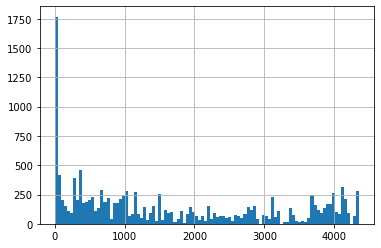

In [397]:
allSuppliersWithWeather.dist.hist(bins = 100)

In [401]:
sum(allSuppliersWithWeather.dist < 500)/allSuppliersWithWeather.shape[0]

0.3063016906975042

### stock data
merge in weather at the location of any supplier. First, get the supplier names only.

In [ ]:
allSupplierData = pd.read_csv("../../data/companyData/allSupplierData.csv").\
    drop(columns = ['Unnamed: 0'])[['gvkey', 'famafrench', 'year','zipcode']]
print(allSupplierData.shape, allSupplierData.columns)

allSupplierData.head()

And merge with the daily weather data.

In [ ]:
allWeather = pd.read_csv("../../data/companyData/stockWeather_zipQuarterQuants.csv").\
    drop(columns = {'Unnamed: 0'})

allWeather = allWeather[~allWeather.temp_zipQuarterLast5.isna()].reset_index(drop = True)

allWeather['date'] = pd.to_datetime(allWeather['date'],
                                   format = "%Y-%m-%d")

allWeather.rename(columns = {'ZIP': 'zipcode'}, inplace = True)
print(allWeather.dtypes)
allWeather.head()


allWeather['year'] = allWeather.date.dt.year

supplierWeather = allSupplierData.merge(allWeather)

In [ ]:
supplierWeather.head()

In [ ]:
supplierWeather.drop(columns = {'zipcode'},inplace = True)
supplierWeather.rename(columns = {'gvkey': 'supplier_gvkey','famafrench': 'supplier_famafrench'},inplace = True)

Now get the actual stock data.

In [ ]:
with open('../../data/stockReturns.pkl', 'rb') as f:
    stocks = pkl.load(f)[['date','gvkey','RET']]

stocks = stocks[stocks.date.dt.year > 2008]

stocks['qtr']  = stocks.date.dt.quarter
stocks['year'] = stocks.date.dt.year

stocks = stocks[~stocks.gvkey.isna()]
stocks['gvkey'] = stocks['gvkey'].astype(int)
print(stocks.shape)

stocks.head()

The controls data.

In [ ]:
igChanges = pd.read_csv("../../data/companyData/igData.csv").\
    drop(columns = {'Unnamed: 0'})
igChanges.head()

companyControls = igChanges[['gvkey','year','qtr','famafrench','ageTercile','sizeTercile','profitTercile','zipcode']]
companyControls.head()

And merge it all together.

In [ ]:
customerDB['gvkey'] = customerDB.gvkey.astype('int64')

In [ ]:
supplierStocks = customerDB.merge(companyControls).merge(stocks).merge(supplierWeather)
print(supplierStocks.shape)

supplierStocks.head()

In [ ]:
supplierStocks.to_csv("../../data/companyData/supplierStocks.csv")

## Biggest Supplier
Focus on weather of biggest supplier.

First find the max by supplier. Add back in any rows with only 1 supplier.

In [410]:
print(customerDB.shape)
customerDB['gvkey'] = customerDB['gvkey'].astype('int64')


customerDB = customerDB[['year','gvkey','totalExp','suppliers']].drop_duplicates()


customerDB.head()

(34007, 4)


,year,gvkey,totalExp,suppliers
0,2002,2136,892.202,13
13,2003,2136,1100.784,14
27,2004,2136,1445.879,21
48,2005,2136,2251.035,32
80,2006,2136,2563.791,31


Merge in the total sales information.

In [413]:
allSuppliersWithWeather = allSuppliersWithWeather.merge(customerDB)

In [414]:
allSuppliersWithWeather.dist

0          50
1          50
2          50
3          50
4         964
         ... 
13658    1687
13659       1
13660       1
13661       1
13662       1
Name: dist, Length: 13663, dtype: int64

In [416]:
allSuppliersWithWeather.head()

,gvkey,datadate,year,qtr,companyName,curcdq,assets,cash,costGoodsSold,totalInv,...,supplier_lag4_temp_zipMonth90_95,supplier_lag4_temp_zipMonth95_99,supplier_lag4_temp_zipMonth99_1,supplier_lag4_temp_zipQuarter50_90,supplier_lag4_temp_zipQuarter90_95,supplier_lag4_temp_zipQuarter95_99,supplier_lag4_temp_zipQuarter99_1,supplier_lag4_days90Plus,supplier_lag4_streak90Plus,dist
0,3336,20100331,2010,1,DXC TECHNOLOGY CO,USD,19766.485192,3344.265863,3989.334386,1119.560267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,50
1,3336,20100630,2010,2,DXC TECHNOLOGY CO,USD,19224.113147,2917.100736,3797.621903,1208.769874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,50
2,3336,20100930,2010,3,DXC TECHNOLOGY CO,USD,20132.213022,3167.601705,3752.958287,1338.809452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,50
3,3336,20101231,2010,4,DXC TECHNOLOGY CO,USD,18727.289468,1936.199197,3828.420879,1417.977681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,50
4,2285,20100331,2010,1,BOEING CO,USD,75437.303227,5411.311715,14014.063413,22489.828386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,964


In [421]:
allSuppliersWithWeather.dist.shape
allSuppliersWithWeather_more500k = allSuppliersWithWeather[allSuppliersWithWeather.dist >= 500]

# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby

idx = allSuppliersWithWeather_more500k.groupby(['year','gvkey']).salecs.\
    transform(max) == allSuppliersWithWeather_more500k.salecs
largestSuppliers_more500k = allSuppliersWithWeather_more500k[idx].reset_index(drop = True)
print(largestSuppliers_more500k.shape)

# find companies who only have one other supplier
singleSuppliers_more500k = allSuppliersWithWeather_more500k[allSuppliersWithWeather_more500k.suppliers == 1].reset_index(drop = True)
print(singleSuppliers_more500k.shape)

# find largest suppliers of different companies
largestSuppliers_more500k = largestSuppliers_more500k.append(singleSuppliers_more500k).drop_duplicates()
print(largestSuppliers_more500k.shape)



largestSuppliersWithWeather_more500k.shape

(2984, 726)
(1005, 726)
(3571, 726)


(9478, 726)

In [422]:
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby

print(allSuppliersWithWeather.shape)

idx = allSuppliersWithWeather.groupby(['year','gvkey']).salecs.\
    transform(max) == allSuppliersWithWeather.salecs
largestSuppliers = allSuppliersWithWeather[idx].reset_index(drop = True)
print(largestSuppliers.shape)

# find companies who only have one other supplier
singleSuppliers = allSuppliersWithWeather[allSuppliersWithWeather.suppliers == 1].reset_index(drop = True)
print(singleSuppliers.shape)

# find largest suppliers of different companies
largestSuppliers = largestSuppliers.append(singleSuppliers).drop_duplicates()
print(largestSuppliers.shape)



(13663, 726)
(4262, 726)
(1621, 726)
(5004, 726)


In [423]:
largestSuppliers.head()

,gvkey,datadate,year,qtr,companyName,curcdq,assets,cash,costGoodsSold,totalInv,...,supplier_lag4_temp_zipMonth90_95,supplier_lag4_temp_zipMonth95_99,supplier_lag4_temp_zipMonth99_1,supplier_lag4_temp_zipQuarter50_90,supplier_lag4_temp_zipQuarter90_95,supplier_lag4_temp_zipQuarter95_99,supplier_lag4_temp_zipQuarter99_1,supplier_lag4_days90Plus,supplier_lag4_streak90Plus,dist
0,3336,20100331,2010,1,DXC TECHNOLOGY CO,USD,19766.485192,3344.265863,3989.334386,1119.560267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,50
1,3336,20100630,2010,2,DXC TECHNOLOGY CO,USD,19224.113147,2917.100736,3797.621903,1208.769874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,50
2,3336,20100930,2010,3,DXC TECHNOLOGY CO,USD,20132.213022,3167.601705,3752.958287,1338.809452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,50
3,3336,20101231,2010,4,DXC TECHNOLOGY CO,USD,18727.289468,1936.199197,3828.420879,1417.977681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,50
4,2285,20100331,2010,1,BOEING CO,USD,75437.303227,5411.311715,14014.063413,22489.828386,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,951


Merge in the change data for that gvkey.

In [424]:
largestSuppliersWithWeather.to_csv("../../data/companyData/largestSuppliersWithWeather.csv")
largestSuppliersWithWeather_more500k.to_csv("../../data/companyData/largestSuppliersWithWeather_more500K.csv")

## Sales-Weighted Average
If a company doesn't have sales-specific information, then assume equal shares. This doesn't happen for too many of the companies, thankfully.

In [ ]:
customerDB = c_links[['year','customer_gvkey','supplier_gvkey','salecs']].\
    merge(custExp).rename(columns = {'customer_gvkey': 'gvkey'}).drop_duplicates()

customerDB['salesWeight'] = customerDB.salecs/customerDB.totalExp

customerDB.fillna(1, inplace = True)

Now merge this with the supplier weather data, and use the sales weights to find a sales-weighted average of the weather conditions for the suppliers.

In [ ]:
relevantVars = [x for x in suppliersWithWeather.columns if (('year' in x) | 
                                                 ('qtr' in x) |
                                                 ('gvkey' in x) |
                                                 ('_' in x)) & 
                                                ~('roa_lagged' in x) & 
                                                ~('yearQtr' in x)]

suppliers_toMerge = suppliersWithWeather[relevantVars]


for colname in suppliers_toMerge.columns[3:]:
    suppliers_toMerge.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

    
suppliers_toMerge.rename(columns = {'gvkey': 'supplier_gvkey'},inplace = True)    


In [ ]:
suppliers_toMerge.head()

For each of the supplier weather columns, multiply the variable by the fraction of sales attributable to that relationship.

In [ ]:
supplierWeather = customerDB[['year','gvkey','supplier_gvkey','salesWeight']].merge(suppliers_toMerge)

for col in supplierWeather.columns[7:]:
        supplierWeather[col]   = supplierWeather.salesWeight*supplierWeather[col]
        
        

supplierWeather.drop(columns = {'supplier_gvkey','salesWeight'}, inplace = True)


print(supplierWeather.head())



# [['year','qtr','gvkey','supplier_tmax_quant_1.0','supplier_precip_quant_1.0']]

In [ ]:
supplierWtdAvgWeather = supplierWeather.groupby(['year','qtr','gvkey']).sum().reset_index().drop_duplicates()

In [ ]:
supplierWtdAvgWeather.gvkey.unique()

Merge the supplier weighted average weather data with the customer data that has weather as well.

In [ ]:
customersWithWeather.head()

In [ ]:
wtdAvgSuppliers = customersWithWeather.merge(supplierWtdAvgWeather)

wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.shape

In [ ]:
wtdAvgSuppliers.to_csv("../../data/companyData/wtdAvgSuppliers.csv")

In [ ]:
wtdAvgSuppliers.head()

In [ ]:
wtdAvgSuppliers.columns[wtdAvgSuppliers.columns.str.contains('Tercile')]